# Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.base import clone

# Import Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab Notebooks/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# EDA

## Eksplorasi awal

In [ ]:
# Menampilkan 5 baris pertama
print(df.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [ ]:
# Menampilkan ringkasan informasi
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
# Menampilkan statistik deskriptif
print(df.describe())

       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000


## Identifikasi missing value

In [ ]:
# Mengubah TotalCharges ke numerik (memaksa string kosong menjadi NaN)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Menghitung nilai kosong setelah konversi
missing_values_count = df.isnull().sum()
missing_values_filtered = missing_values_count[missing_values_count > 0]
total_rows = len(df)
missing_percentage = (missing_values_filtered / total_rows) * 100

if missing_percentage.empty:
    print("Tidak ada missing values yang ditemukan.")
else:
    missing_data = pd.DataFrame({
        'Count': missing_values_filtered,
        'Percentage': missing_percentage.round(4)
    }).sort_values(by='Percentage', ascending=False)
    print(missing_data)

              Count  Percentage
TotalCharges     11      0.1562


/tmp/ipython-input-1260064308.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_percentage.index, y=missing_percentage.values, palette='viridis', width=0.3)


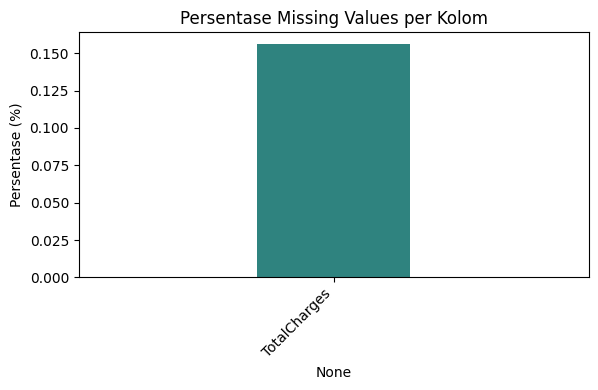

In [ ]:
# Visualisasi Missing Values
plt.figure(figsize=(6, 4))
sns.barplot(x=missing_percentage.index, y=missing_percentage.values, palette='viridis', width=0.3)
plt.title('Persentase Missing Values per Kolom')
plt.ylabel('Persentase (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Visualisasi distribusi target

In [ ]:
# Hitung persentase Churn
churn_counts = df['Churn'].value_counts()
churn_percentage = (churn_counts / len(df)) * 100

print("\n-- Distribusi Persentase Churn --")
print(churn_percentage.to_markdown(numalign="left", stralign="left"))


-- Distribusi Persentase Churn --
| Churn   | count   |
|:--------|:--------|
| No      | 73.463  |
| Yes     | 26.537  |


/tmp/ipython-input-582453938.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, palette='Set1')


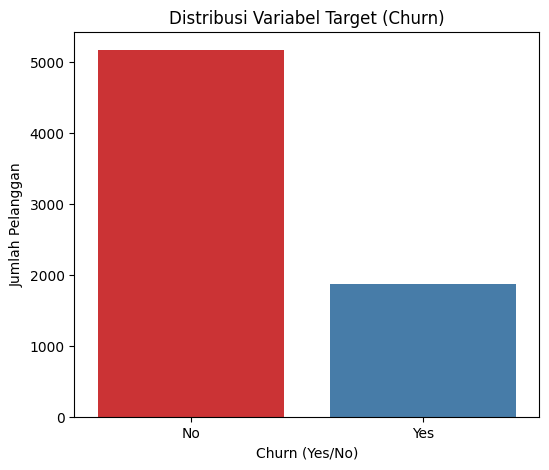

In [ ]:
# Visualisasi Distribusi Variabel Target
plt.figure(figsize=(6, 5))
sns.countplot(x='Churn', data=df, palette='Set1')
plt.title('Distribusi Variabel Target (Churn)')
plt.xlabel('Churn (Yes/No)')
plt.ylabel('Jumlah Pelanggan')
plt.show()

## Analisis korelasi

In [ ]:
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen']
numerical_df = df[numerical_features].copy()

In [ ]:
# Menghitung matriks korelasi
correlation_matrix = numerical_df.corr()

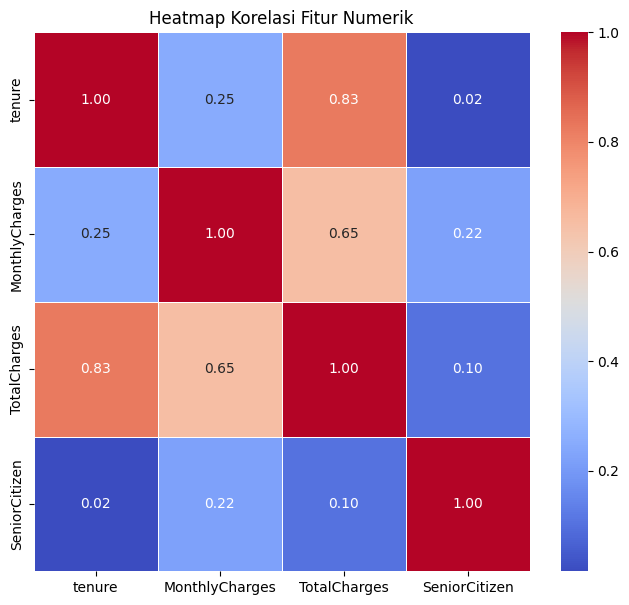

In [ ]:
# Visualisasi Heatmap Korelasi
plt.figure(figsize=(8, 7))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Heatmap Korelasi Fitur Numerik')
plt.show()

# Direct Modeling

In [ ]:
# Penanganan Minimal:
df_direct = df.copy()
df_direct['TotalCharges'] = df_direct['TotalCharges'].fillna(df_direct['TotalCharges'].median())
df_direct.drop('customerID', axis=1, inplace=True)
df_direct['Churn'] = df_direct['Churn'].map({'Yes': 1, 'No': 0})

## Menerapkan variabel X dan Y

In [ ]:
y_direct = df_direct['Churn'] # Target (y)
X_direct = df_direct.drop('Churn', axis=1) # Fitur Prediktor (X)

In [ ]:
# Encoding Fitur Kategorikal (One-Hot Encoding)
X_direct = pd.get_dummies(X_direct, drop_first=True)

## Train–test split

In [ ]:
X_train_direct, X_test_direct, y_train_direct, y_test_direct = train_test_split(
    X_direct, y_direct, test_size=0.3, random_state=42, stratify=y_direct
)

## Pemilihan dan Pelatihan model

In [ ]:
# Konvensional (Logistic Regression)
model_lr_direct = LogisticRegression(max_iter=1000, random_state=42)
# Ensemble Bagging (Random Forest)
model_rf_direct = RandomForestClassifier(random_state=42)
# Ensemble Voting (Kombinasi LR, SVC, KNN)
estimators_direct = [
    ('lr', LogisticRegression(max_iter=1000, random_state=42)),
    ('svc', SVC(probability=True, random_state=42)),
    ('knn', KNeighborsClassifier())
]
model_vc_direct = VotingClassifier(estimators=estimators_direct, voting='soft', n_jobs=-1)

models_direct = {
    "Logistic Regression (Direct)": model_lr_direct,
    "Random Forest (Direct)": model_rf_direct,
    "Voting Classifier (Direct)": model_vc_direct
}

In [ ]:
# Melatih dan mengevaluasi model
results_direct = {}
for name, model in models_direct.items():
    model.fit(X_train_direct, y_train_direct)
    y_pred = model.predict(X_test_direct)
    accuracy = accuracy_score(y_test_direct, y_pred)
    precision = precision_score(y_test_direct, y_pred)
    recall = recall_score(y_test_direct, y_pred)
    f1 = f1_score(y_test_direct, y_pred)
    cm = confusion_matrix(y_test_direct, y_pred)

    results_direct[name] = {
      'Accuracy': accuracy,
      'Precision': precision,
      'Recall': recall,
      'F1-Score': f1,
      'Confusion Matrix': cm
    }

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Evaluasi model

In [ ]:
summary_df_direct = pd.DataFrame([
    {
        'Model': k,
        'Accuracy': v['Accuracy'],
        'Precision': v['Precision'],
        'Recall': v['Recall'],
        'F1-Score': v['F1-Score']
    }
    for k, v in results_direct.items()
]).sort_values(by='F1-Score', ascending=False).reset_index(drop=True)

print("== Ringkasan Hasil Direct Modeling ==")
print(summary_df_direct.to_markdown(index=False, numalign="left", stralign="left"))

== Ringkasan Hasil Direct Modeling ==
| Model                        | Accuracy   | Precision   | Recall   | F1-Score   |
|:-----------------------------|:-----------|:------------|:---------|:-----------|
| Logistic Regression (Direct) | 0.811169   | 0.673077    | 0.561497 | 0.612245   |
| Random Forest (Direct)       | 0.788926   | 0.629797    | 0.497326 | 0.555777   |
| Voting Classifier (Direct)   | 0.789872   | 0.661157    | 0.427807 | 0.519481   |


# Modeling Dengan Preprocessing

## Preprocessing data

### Missing value

In [ ]:
# Mengkonversi TotalCharges ke numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Mengecek jumlah missing value
missing_count = df.isnull().sum().sum()
print(f"\nJumlah Missing Value ditemukan: {missing_count}")

# Handling: Isi (Imputasi) nilai NaN dengan Median
if missing_count > 0:
    median_val = df['TotalCharges'].median()
    df['TotalCharges'] = df['TotalCharges'].fillna(median_val)
    print(f" -> {missing_count} missing value pada 'TotalCharges' telah diisi dengan median ({median_val}).")
else:
    print(" Tidak ada missing value.")


Jumlah Missing Value ditemukan: 11
 -> 11 missing value pada 'TotalCharges' telah diisi dengan median (1397.475).


### Data duplikat

In [ ]:
dup_count = df.duplicated().sum()
if dup_count > 0:
    df.drop_duplicates(inplace=True)
    print(f"{dup_count} dihpaus baris data duplikat.")
else:
    print("Tidak ada data duplikat.")

Tidak ada data duplikat.


### Outlier

In [ ]:
df_temp = df.copy()
le = LabelEncoder()
for col in df_temp.select_dtypes(include=['object']).columns:
    df_temp[col] = le.fit_transform(df_temp[col])

iso = IsolationForest(contamination=0.05, random_state=42)
outlier_labels = iso.fit_predict(df_temp) # Output: -1 (Outlier), 1 (Normal)

df_clean = df[outlier_labels == 1].copy()

outlier_count = (outlier_labels == -1).sum()
print(f"Ditemukan {outlier_count} data outlier.")
print(f"Ukuran data sebelum: {df.shape}")
print(f"Ukuran data sesudah: {df_clean.shape}")

Ditemukan 353 data outlier.
Ukuran data sebelum: (7043, 21)
Ukuran data sesudah: (6690, 21)


### Encoding, penghapusan dan penyesuaian fitur

In [ ]:
# Pisahkan Target (y) dan Fitur (X)
y_prep = df_clean['Churn'].map({'Yes': 1, 'No': 0})
X_prep = df_clean.drop(['Churn', 'customerID'], axis=1)

# Melakukan One-Hot Encoding (OHE) pada Fitur drop_first=True untuk menghindari redundansi kolom
X_prep = pd.get_dummies(X_prep, drop_first=True)

print(f"Shape Fitur (X): {X_prep.shape}")
print(f"Shape Target (y): {y_prep.shape}")

Shape Fitur (X): (6690, 30)
Shape Target (y): (6690,)


### Scalling

In [ ]:
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
X_prep[numerical_features] = scaler.fit_transform(X_prep[numerical_features])

## Train-Test Split

In [ ]:
X_train_prep, X_test_prep, y_train_prep, y_test_prep = train_test_split(
    X_prep, y_prep, test_size=0.3, random_state=42, stratify=y_prep
)

print("Dimensi Train:", X_train_prep.shape)
print("Dimensi Test:", X_test_prep.shape)

Dimensi Train: (4683, 30)
Dimensi Test: (2007, 30)


## Pelatihan Model (Dengan Data Preprocessing)

## Evaluasi dan Perbandingan

In [ ]:
# Siapkan Wadah (Bank Model)
bank_model = {}
hasil_evaluasi = []

# Model Dasar
models_to_test = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Voting Classifier": VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(max_iter=1000, random_state=42)),
            ('svc', SVC(probability=True, random_state=42)),
            ('knn', KNeighborsClassifier())
        ], voting='soft', n_jobs=-1
    )
}

# Lakukan Resampling
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_prep, y_train_prep)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_prep, y_train_prep)

# 4. Loop Training (Original vs Undersampling vs SMOTE)
skenario_data = [
    ("Original", X_train_prep, y_train_prep),
    ("Undersampling", X_train_rus, y_train_rus),
    ("SMOTE", X_train_smote, y_train_smote)
]

for nama_skenario, X_tr, y_tr in skenario_data:
    for nama_model, model_dasar in models_to_test.items():
        # Nama unik
        nama_lengkap = f"{nama_model} ({nama_skenario})"

        # Clone & Train
        clf = clone(model_dasar)
        clf.fit(X_tr, y_tr)

        # Test ke data asli
        y_pred = clf.predict(X_test_prep)

        # Simpan
        bank_model[nama_lengkap] = clf
        hasil_evaluasi.append({
            "Model": nama_lengkap,
            "F1-Score": f1_score(y_test_prep, y_pred),
            "Accuracy": accuracy_score(y_test_prep, y_pred),
            "Precision": precision_score(y_test_prep, y_pred),
            "Recall": recall_score(y_test_prep, y_pred)
        })

# Tampilkan hasil sementara
print(pd.DataFrame(hasil_evaluasi).sort_values(by="F1-Score", ascending=False).to_markdown(index=False))

| Model                               |   F1-Score |   Accuracy |   Precision |   Recall |
|:------------------------------------|-----------:|-----------:|------------:|---------:|
| Logistic Regression (SMOTE)         |   0.627027 |   0.759342 |    0.527958 | 0.771863 |
| Random Forest (Undersampling)       |   0.625571 |   0.754858 |    0.521574 | 0.781369 |
| Logistic Regression (Undersampling) |   0.624726 |   0.744395 |    0.507729 | 0.811787 |
| Voting Classifier (Undersampling)   |   0.617052 |   0.735924 |    0.497669 | 0.811787 |
| Voting Classifier (SMOTE)           |   0.615975 |   0.750872 |    0.516753 | 0.762357 |
| Logistic Regression (Original)      |   0.606061 |   0.80568  |    0.646552 | 0.570342 |
| Random Forest (SMOTE)               |   0.596913 |   0.76582  |    0.54375  | 0.661597 |
| Voting Classifier (Original)        |   0.590576 |   0.805182 |    0.657343 | 0.536122 |
| Random Forest (Original)            |   0.580442 |   0.801196 |    0.649412 | 0.524715 |

# Hyperparameter Tuning

## Menyusun parameter grid

In [ ]:
# Grid untuk Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

In [ ]:
# Grid untuk Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

In [ ]:
# Grid untuk Voting Classifier
param_grid_vc = {
    'weights': [[1, 1, 1], [2, 1, 1], [1, 2, 1], [1, 1, 2]]
}

## Proses Hyperparamater Tuning

In [ ]:
estimators_prep = [
    ('lr', LogisticRegression(max_iter=1000, random_state=42)),
    ('svc', SVC(probability=True, random_state=42)),
    ('knn', KNeighborsClassifier())
]
model_vc_prep = VotingClassifier(estimators=estimators_prep, voting='soft', n_jobs=-1)

In [ ]:
tuning_configs = [
    ("Logistic Regression", LogisticRegression(max_iter=1000, random_state=42), param_grid_lr),
    ("Random Forest", RandomForestClassifier(random_state=42), param_grid_rf),
    ("Voting Classifier", model_vc_prep, param_grid_vc)
]

results_tuning = {}
best_models = {}

for name, model, grid in tuning_configs:
  print(f"\nTraining {name} dengan GridSearchCV...")

  # Inisialisasi GridSearchCV
  grid_search = GridSearchCV(estimator=model, param_grid=grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)

  # Latih dengan data latih
  grid_search.fit(X_train_smote, y_train_smote)

  # Ambil model terbaik
  best_model = grid_search.best_estimator_
  best_params = grid_search.best_params_

  # Menyimpan di dictionary 'best_models' agar bisa diambil di tahap akhir
  best_models[name] = best_model

  print(f" Parameter terbaik : {best_params}")


Training Logistic Regression dengan GridSearchCV...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
 Parameter terbaik : {'C': 10, 'solver': 'liblinear'}

Training Random Forest dengan GridSearchCV...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
 Parameter terbaik : {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}

Training Voting Classifier dengan GridSearchCV...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
 Parameter terbaik : {'weights': [1, 1, 2]}


## Evaluasi

In [ ]:
# Evaluasi Ulang Semua Model
results_tuning = {}

# ambil model yang sudah disimpan di dictionary 'best_models' pada cell sebelumnya
for name, model in best_models.items():
    # Prediksi
    y_pred_tuned = model.predict(X_test_prep)

    # Hitung Metrik
    results_tuning[name] = {
        'Accuracy': accuracy_score(y_test_prep, y_pred_tuned),
        'Precision': precision_score(y_test_prep, y_pred_tuned),
        'Recall': recall_score(y_test_prep, y_pred_tuned),
        'F1-Score': f1_score(y_test_prep, y_pred_tuned),
        'Best Params': str(model.get_params()) # Ambil parameter dari objek model
    }

In [ ]:
summary_df_tuning = pd.DataFrame([
    {
        'Model': k,
        'Accuracy': v['Accuracy'],
        'Precision': v['Precision'],
        'Recall': v['Recall'],
        'F1-Score': v['F1-Score'],
        'Best Params': v['Best Params']
    }
    for k, v in results_tuning.items()
]).sort_values(by='F1-Score', ascending=False).reset_index(drop=True)

# Tampilkan Hasil
print("== Ringkasan Hasil Hyperparameter Tuning (Semua Model) ==")
print(summary_df_tuning.to_markdown(index=False, numalign="left", stralign="left"))

# Pilih Model Terbaik
best_model_name = summary_df_tuning.iloc[0]['Model']
final_model = best_models[best_model_name]

print(f"\nModel terbaik: {best_model_name}")

== Ringkasan Hasil Hyperparameter Tuning (Semua Model) ==
| Model               | Accuracy   | Precision   | Recall   | F1-Score   | Best Params                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [ ]:
if 'best_models' in globals():
    for nama, model_tuned in best_models.items():
        y_pred = model_tuned.predict(X_test_prep)
        nama_lengkap = f"{nama} (Tuned)"

        bank_model[nama_lengkap] = model_tuned
        hasil_evaluasi.append({
            "Model": nama_lengkap,
            "Accuracy": accuracy_score(y_test_prep, y_pred),
            "Precision": precision_score(y_test_prep, y_pred),
            "Recall": recall_score(y_test_prep, y_pred),
            "F1-Score": f1_score(y_test_prep, y_pred)
        })

# Cari Pemenang Utama
df_final = pd.DataFrame(hasil_evaluasi).sort_values(by="F1-Score", ascending=False).reset_index(drop=True)

print("=== KLASEMEN AKHIR (Semua Model) ===")
print(df_final.head(10).to_markdown(index=False))

juara_nama = df_final.iloc[0]['Model']
juara_model = bank_model[juara_nama]

print(f"\n Model Terbaik: {juara_nama}")
print(f"F1-Score: {df_final.iloc[0]['F1-Score']:.4f}")

# Simpan
artifacts = {
    "model": juara_model,
    "scaler": scaler,
    "features": X_train_prep.columns.tolist()
}

joblib.dump(artifacts, 'churn_model.pkl')

=== KLASEMEN AKHIR (Semua Model) ===
| Model                               |   F1-Score |   Accuracy |   Precision |   Recall |
|:------------------------------------|-----------:|-----------:|------------:|---------:|
| Logistic Regression (SMOTE)         |   0.627027 |   0.759342 |    0.527958 | 0.771863 |
| Random Forest (Undersampling)       |   0.625571 |   0.754858 |    0.521574 | 0.781369 |
| Logistic Regression (Undersampling) |   0.624726 |   0.744395 |    0.507729 | 0.811787 |
| Logistic Regression (Tuned)         |   0.622642 |   0.760837 |    0.530831 | 0.752852 |
| Random Forest (Tuned)               |   0.617369 |   0.778276 |    0.563579 | 0.68251  |
| Voting Classifier (Undersampling)   |   0.617052 |   0.735924 |    0.497669 | 0.811787 |
| Voting Classifier (SMOTE)           |   0.615975 |   0.750872 |    0.516753 | 0.762357 |
| Voting Classifier (Tuned)           |   0.609292 |   0.744395 |    0.508259 | 0.760456 |
| Logistic Regression (Original)      |   0.606061 | 

['churn_model.pkl']